In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os
import re
import unicodedata

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36"
}

def slugify(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return re.sub(r'[^a-z0-9]+', '-', text.lower()).strip('-')

def extract_price(text):
    if not text or not any(c.isdigit() for c in text):
        return None
    cleaned = re.sub(r'[^\d.,]', '', text.replace(' ', '').replace(',', '.'))
    try:
        return float(cleaned)
    except ValueError:
        return None

def extract_city(location):
    parts = [p.strip() for p in location.split(',')]
    return parts[-1] if parts else location.strip()

def extract_features(ann):
    features = ann.find_all('div', class_='adDetailFeature')
    out = dict(Surface=None, Pieces=None, Chambres=None, SallesDeBain=None)
    for f in features:
        icon = f.find('i', class_=True)
        txt = f.find('span').get_text(strip=True) if f.find('span') else ''
        cls = ' '.join(icon['class']) if icon else ''
        if 'icon-triangle' in cls:
            m = re.search(r'(\d+[\.,]?\d*)\s*m²', txt)
            out['Surface'] = float(m.group(1).replace(',', '.')) if m else None
        elif 'icon-house-boxes' in cls:
            m = re.search(r'(\d+)', txt)
            out['Pieces'] = int(m.group(1)) if m else None
        elif 'icon-bed' in cls:
            m = re.search(r'(\d+)', txt)
            out['Chambres'] = int(m.group(1)) if m else None
        elif 'icon-bath' in cls:
            m = re.search(r'(\d+)', txt)
            out['SallesDeBain'] = int(m.group(1)) if m else None
    return out

def get_type_bien(detail_url):
    try:
        resp = requests.get(detail_url, headers=headers)
        if resp.status_code != 200:
            return None
        soup = BeautifulSoup(resp.text, 'html.parser')
        div = soup.find('div', class_='adMainFeatureContent')
        if div:
            lbl = div.find('p', class_='adMainFeatureContentLabel')
            val = div.find('p', class_='adMainFeatureContentValue')
            if lbl and lbl.get_text(strip=True) == "Type de bien" and val:
                return val.get_text(strip=True)
        return None
    except Exception as e:
        print(f"Erreur lors de l'extraction du type de bien : {e}")
        return None

def scrape_city(city_code, city_name, data, max_pages=5):
    base = f"https://www.mubawab.ma/fr/ct/{city_code}/immobilier-a-vendre"
    for page in range(1, max_pages + 1):
        url = f"{base}:p:{page}"
        print(f"📄 Scraping {city_name} - Page {page} : {url}")
        resp = requests.get(url, headers=headers)
        if resp.status_code != 200:
            print(f"[{city_name}] Erreur {resp.status_code} page {page}")
            break
        soup = BeautifulSoup(resp.text, 'html.parser')
        anns = soup.find_all('div', class_='listingBox')
        if not anns:
            break
        for ann in anns:
            try:
                price_tag = ann.find('span', class_='priceTag')
                title_el = ann.find('h2', class_='listingTit')
                loc_el = ann.find('span', class_='listingH3')
                aid_el = ann.find('input', class_='adId')

                price = extract_price(price_tag.get_text(strip=True)) if price_tag else None
                title = title_el.get_text(strip=True) if title_el else ""
                ville = extract_city(loc_el.get_text(strip=True)) if loc_el else city_name
                aid = aid_el.get('value') if aid_el else None
                feats = extract_features(ann)

                typ = None
                if aid and title:
                    slug = slugify(title)
                    detail_url = f"https://www.mubawab.ma/fr/pa/{aid}/{slug}"
                    typ = get_type_bien(detail_url)
                    time.sleep(1)  # Respect des limites serveur

                data.append({
                    "Prix": price,
                    "Ville": ville,
                    "Titre": title,
                    **feats,
                    "TypeBien": typ
                })
            except Exception as e:
                print(f"❌ Erreur traitement annonce: {e}")
                continue
        time.sleep(0.5)

def scrape_all():
    data = []
    cities = [
        ("casablanca", "Casablanca"),
        ("rabat", "Rabat"),
        ("marrakech", "Marrakech"),
        ("tanger", "Tanger"),
        ("agadir", "Agadir"),
        ("fes", "Fès")
    ]
    for code, name in cities:
        print(f"\n🗺️ Scraping {name}")
        scrape_city(code, name, data, max_pages=3)  # <--- ajuste ici si tu veux plus de pages
    df = pd.DataFrame(data)
    os.makedirs('data', exist_ok=True)
    df.to_csv('data/mubawab_multi_city.csv', index=False)
    print(f"\n✅ Scraping terminé : {len(df)} annonces collectées.")
    return df

if __name__ == "__main__":
    scrape_all()



🗺️ Scraping Casablanca
📄 Scraping Casablanca - Page 1 : https://www.mubawab.ma/fr/ct/casablanca/immobilier-a-vendre:p:1
📄 Scraping Casablanca - Page 2 : https://www.mubawab.ma/fr/ct/casablanca/immobilier-a-vendre:p:2
📄 Scraping Casablanca - Page 3 : https://www.mubawab.ma/fr/ct/casablanca/immobilier-a-vendre:p:3

🗺️ Scraping Rabat
📄 Scraping Rabat - Page 1 : https://www.mubawab.ma/fr/ct/rabat/immobilier-a-vendre:p:1
📄 Scraping Rabat - Page 2 : https://www.mubawab.ma/fr/ct/rabat/immobilier-a-vendre:p:2
📄 Scraping Rabat - Page 3 : https://www.mubawab.ma/fr/ct/rabat/immobilier-a-vendre:p:3

🗺️ Scraping Marrakech
📄 Scraping Marrakech - Page 1 : https://www.mubawab.ma/fr/ct/marrakech/immobilier-a-vendre:p:1
📄 Scraping Marrakech - Page 2 : https://www.mubawab.ma/fr/ct/marrakech/immobilier-a-vendre:p:2
📄 Scraping Marrakech - Page 3 : https://www.mubawab.ma/fr/ct/marrakech/immobilier-a-vendre:p:3

🗺️ Scraping Tanger
📄 Scraping Tanger - Page 1 : https://www.mubawab.ma/fr/ct/tanger/immobilier-a

In [11]:
df = scrape_all()


🗺️ Scraping Casablanca
📄 Scraping Casablanca - Page 1 : https://www.mubawab.ma/fr/ct/casablanca/immobilier-a-vendre:p:1
📄 Scraping Casablanca - Page 2 : https://www.mubawab.ma/fr/ct/casablanca/immobilier-a-vendre:p:2
📄 Scraping Casablanca - Page 3 : https://www.mubawab.ma/fr/ct/casablanca/immobilier-a-vendre:p:3

🗺️ Scraping Rabat
📄 Scraping Rabat - Page 1 : https://www.mubawab.ma/fr/ct/rabat/immobilier-a-vendre:p:1
📄 Scraping Rabat - Page 2 : https://www.mubawab.ma/fr/ct/rabat/immobilier-a-vendre:p:2
📄 Scraping Rabat - Page 3 : https://www.mubawab.ma/fr/ct/rabat/immobilier-a-vendre:p:3

🗺️ Scraping Marrakech
📄 Scraping Marrakech - Page 1 : https://www.mubawab.ma/fr/ct/marrakech/immobilier-a-vendre:p:1
📄 Scraping Marrakech - Page 2 : https://www.mubawab.ma/fr/ct/marrakech/immobilier-a-vendre:p:2
📄 Scraping Marrakech - Page 3 : https://www.mubawab.ma/fr/ct/marrakech/immobilier-a-vendre:p:3

🗺️ Scraping Tanger
📄 Scraping Tanger - Page 1 : https://www.mubawab.ma/fr/ct/tanger/immobilier-a

In [13]:
print(df.isnull())

      Prix  Ville  Titre  Surface  Pieces  Chambres  SallesDeBain  TypeBien
0    False  False  False    False    True      True          True     False
1    False  False  False    False   False     False         False     False
2    False  False  False    False   False     False         False     False
3    False  False  False    False    True     False         False     False
4    False  False  False    False   False     False         False     False
..     ...    ...    ...      ...     ...       ...           ...       ...
517  False  False  False    False   False     False         False     False
518  False  False  False    False   False     False         False     False
519  False  False  False    False   False     False         False     False
520  False  False  False    False   False     False         False     False
521   True  False  False     True    True      True          True      True

[522 rows x 8 columns]


In [14]:
print(df.isnull().sum())

Prix            44
Ville            0
Titre            0
Surface         27
Pieces          40
Chambres        32
SallesDeBain    34
TypeBien        27
dtype: int64


In [15]:
df['Prix'].fillna(df['Prix'].mean() , inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\335827402.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Prix'].fillna(df['Prix'].mean() , inplace=True)


In [16]:
df['Surface'].fillna(df['Surface'].mean() , inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\702119148.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Surface'].fillna(df['Surface'].mean() , inplace=True)


In [17]:
print(df.isnull().sum())

Prix             0
Ville            0
Titre            0
Surface          0
Pieces          40
Chambres        32
SallesDeBain    34
TypeBien        27
dtype: int64


In [18]:
df['Chambres'].fillna(df['Chambres'].mean() , inplace=True)
df['Pieces'].fillna(df['Pieces'].mean() , inplace=True)
df['SallesDeBain'].fillna(df['SallesDeBain'].mean() , inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\1411812574.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Chambres'].fillna(df['Chambres'].mean() , inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\1411812574.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [19]:
print(df.isnull().sum())

Prix             0
Ville            0
Titre            0
Surface          0
Pieces           0
Chambres         0
SallesDeBain     0
TypeBien        27
dtype: int64


In [20]:
df['TypeBien'].fillna(df['TypeBien'].mode()[0] , inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\2805991739.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TypeBien'].fillna(df['TypeBien'].mode()[0] , inplace=True)


In [21]:
print(df.isnull().sum())

Prix            0
Ville           0
Titre           0
Surface         0
Pieces          0
Chambres        0
SallesDeBain    0
TypeBien        0
dtype: int64


In [29]:
df.duplicated().sum()

np.int64(16)

In [30]:
df[df.duplicated()]

,Prix,Ville,Titre,Surface,Pieces,Chambres,SallesDeBain,TypeBien
35,1.520000e+06,Casablanca,"Très bel appartement de 108 m2, Casa, Belvedere",108.000000,4.000000,2.000000,2.000000,Appartement
69,3.903889e+06,Casablanca,,306.751515,4.369295,3.042857,2.391393,Appartement
104,3.903889e+06,Casablanca,,306.751515,4.369295,3.042857,2.391393,Appartement
147,1.328000e+06,Temara,Résidence Yasmine Temara,306.751515,4.369295,3.042857,2.391393,Appartement
164,1.500000e+07,Rabat,Un magnifique villa à vendre,2200.000000,6.000000,5.000000,5.000000,Villa
174,3.903889e+06,Rabat,,306.751515,4.369295,3.042857,2.391393,Appartement
196,3.500000e+06,Rabat,Appartement à vendre Prestigia Rabat,143.000000,4.000000,3.000000,2.000000,Appartement
200,3.700000e+06,Rabat,Appartement à vendre Hay Riad Rabat,192.000000,5.000000,3.000000,2.000000,Appartement
209,3.903889e+06,Rabat,,306.751515,4.369295,3.042857,2.391393,Appartement
279,3.903889e+06,Marrakech,,306.751515,4.369295,3.042857,2.391393,Appartement


In [32]:
df = df.drop_duplicates()

In [33]:
df.duplicated().sum()

np.int64(0)

In [43]:
outliers ={}
for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask =(df[col] < Q1-12 * IQR )  | (df[col] > Q3+12 * IQR )
    outliers[col] = outlier_mask.sum()


In [44]:
print(outliers)

{'Prix': np.int64(1), 'Surface': np.int64(1), 'Pieces': np.int64(0), 'Chambres': np.int64(0), 'SallesDeBain': np.int64(0)}


In [45]:
Df_out=df[outlier_mask]
print(Df_out)

Empty DataFrame
Columns: [Prix, Ville, Titre, Surface, Pieces, Chambres, SallesDeBain, TypeBien]
Index: []


In [47]:
pd.Series(outliers)

Prix            1
Surface         1
Pieces          0
Chambres        0
SallesDeBain    0
dtype: int64

In [49]:
df = df.drop('Titre', axis=1)

In [50]:
df

,Prix,Ville,Surface,Pieces,Chambres,SallesDeBain,TypeBien
0,877500.0,Casablanca,65.0,4.369295,3.042857,2.391393,Appartement
1,1750000.0,Casablanca,114.0,3.000000,2.000000,2.000000,Appartement
2,2237000.0,Casablanca,127.0,4.000000,3.000000,2.000000,Appartement
3,690001.0,Casablanca,45.0,4.369295,2.000000,2.000000,Appartement
4,980000.0,Casablanca,43.0,2.000000,1.000000,1.000000,Appartement
...,...,...,...,...,...,...,...
516,1100000.0,Agadir,125.0,4.000000,3.000000,4.000000,Appartement
517,740000.0,Agadir,92.0,1.000000,2.000000,1.000000,Maison
518,740000.0,Agadir,92.0,1.000000,2.000000,1.000000,Appartement
519,740000.0,Agadir,96.0,1.000000,2.000000,1.000000,Appartement


In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Ville'] = le.fit_transform(df['Ville'])
df['TypeBien'] = le.fit_transform(df['TypeBien'])


In [52]:
df

,Prix,Ville,Surface,Pieces,Chambres,SallesDeBain,TypeBien
0,877500.0,1,65.0,4.369295,3.042857,2.391393,0
1,1750000.0,1,114.0,3.000000,2.000000,2.000000,0
2,2237000.0,1,127.0,4.000000,3.000000,2.000000,0
3,690001.0,1,45.0,4.369295,2.000000,2.000000,0
4,980000.0,1,43.0,2.000000,1.000000,1.000000,0
...,...,...,...,...,...,...,...
516,1100000.0,0,125.0,4.000000,3.000000,4.000000,0
517,740000.0,0,92.0,1.000000,2.000000,1.000000,1
518,740000.0,0,92.0,1.000000,2.000000,1.000000,0
519,740000.0,0,96.0,1.000000,2.000000,1.000000,0


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Style esthétique
sns.set(style="whitegrid")


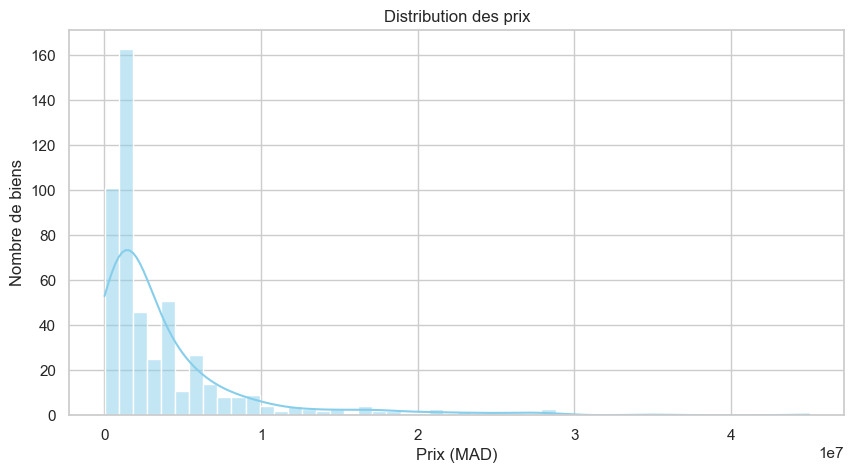

In [54]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Prix'].dropna(), bins=50, kde=True, color='skyblue')
plt.title('Distribution des prix')
plt.xlabel('Prix (MAD)')
plt.ylabel('Nombre de biens')
plt.show()


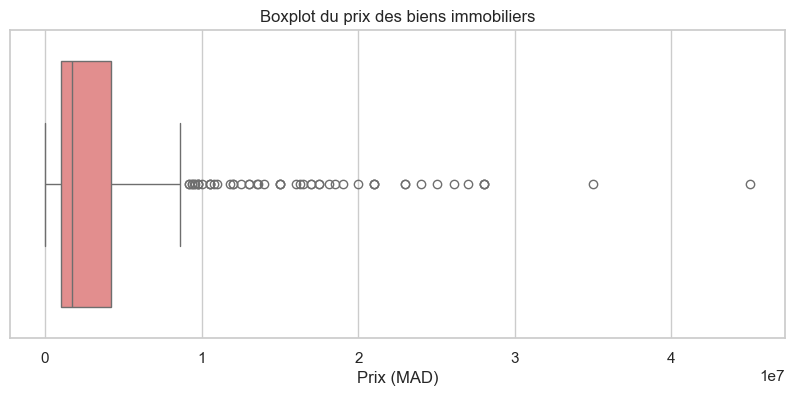

In [55]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Prix'], color='lightcoral')
plt.title('Boxplot du prix des biens immobiliers')
plt.xlabel('Prix (MAD)')
plt.show()


In [56]:
import seaborn as sns
import matplotlib.pyplot as plt


In [57]:
# On garde uniquement les colonnes numériques pertinentes
numerical_df = df[['Prix', 'Surface', 'Pieces', 'Chambres', 'SallesDeBain']].copy()


In [58]:
correlation_matrix = numerical_df.corr()


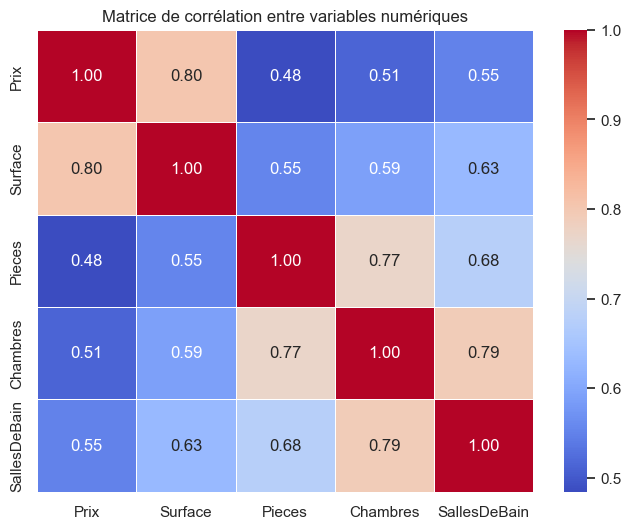

In [59]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de corrélation entre variables numériques')
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\570870500.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_price_by_city.index, y=mean_price_by_city.values, palette='viridis')


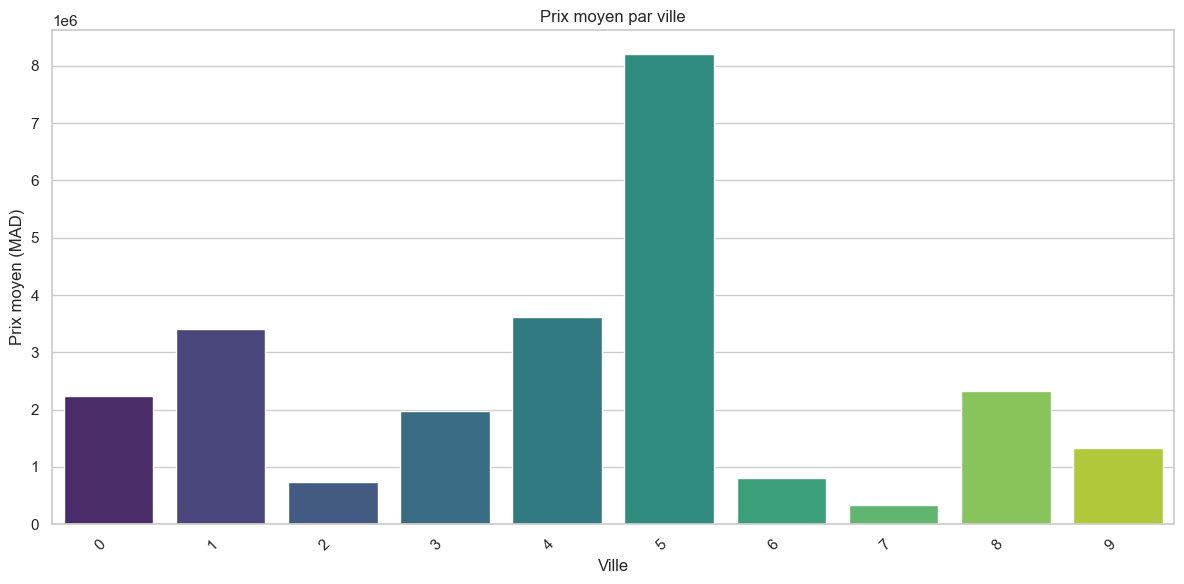

In [60]:
plt.figure(figsize=(12, 6))
mean_price_by_city = df.groupby('Ville')['Prix'].mean().sort_values(ascending=False)
sns.barplot(x=mean_price_by_city.index, y=mean_price_by_city.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Prix moyen par ville')
plt.ylabel('Prix moyen (MAD)')
plt.xlabel('Ville')
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\2394515488.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_price_by_type.index, y=mean_price_by_type.values, palette='magma')


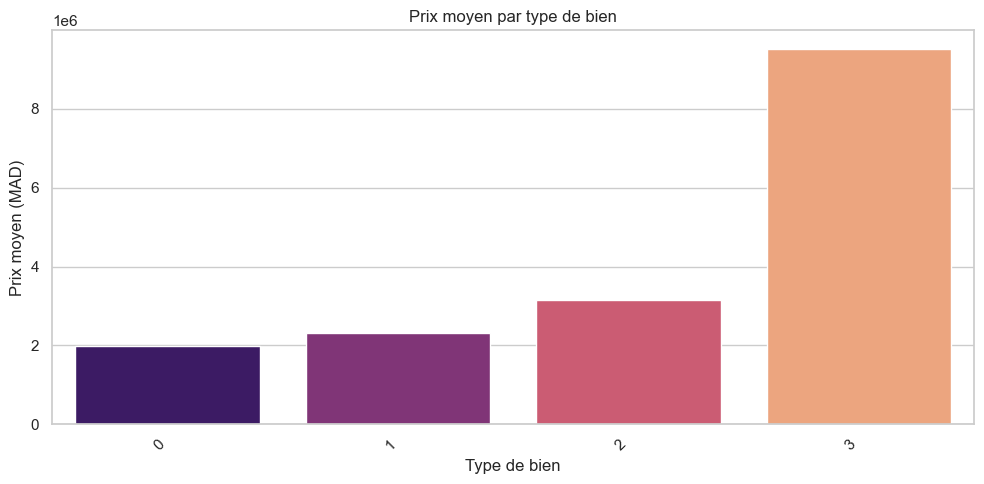

In [61]:
plt.figure(figsize=(10, 5))
mean_price_by_type = df.groupby('TypeBien')['Prix'].mean().sort_values(ascending=False)
sns.barplot(x=mean_price_by_type.index, y=mean_price_by_type.values, palette='magma')
plt.xticks(rotation=45, ha='right')
plt.title('Prix moyen par type de bien')
plt.ylabel('Prix moyen (MAD)')
plt.xlabel('Type de bien')
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\1754200938.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ville', y='Prix', data=df, palette='Set2')


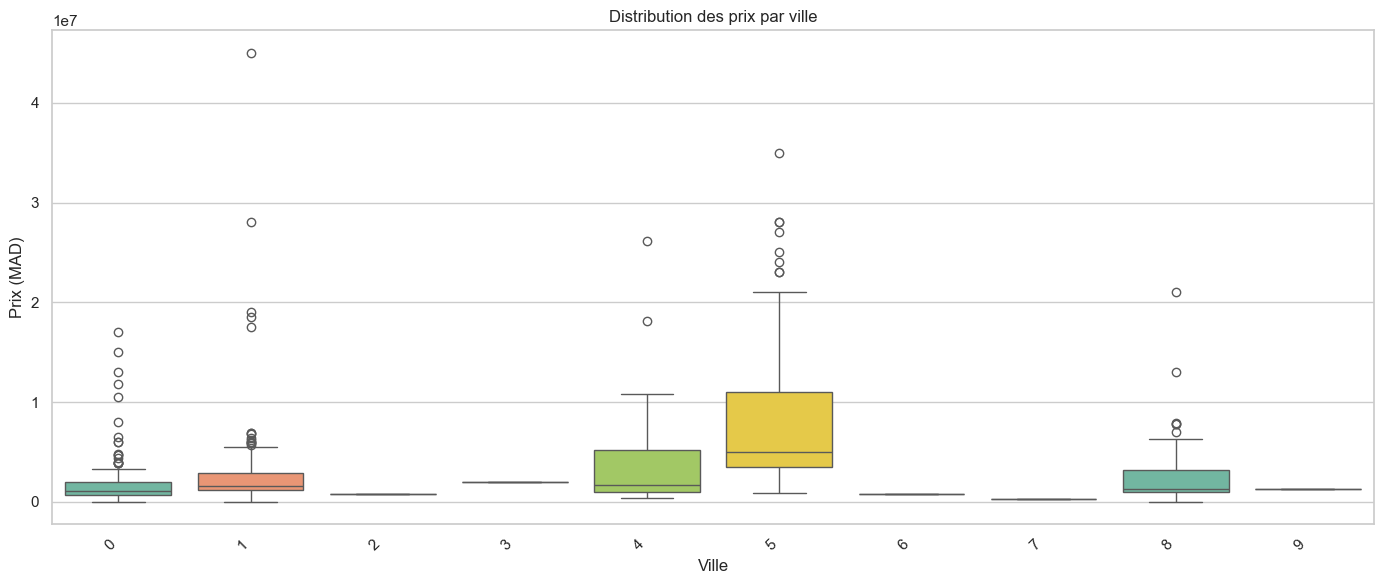

In [62]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Ville', y='Prix', data=df, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution des prix par ville')
plt.ylabel('Prix (MAD)')
plt.xlabel('Ville')
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\1391918742.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TypeBien', y='Prix', data=df, palette='Set3')


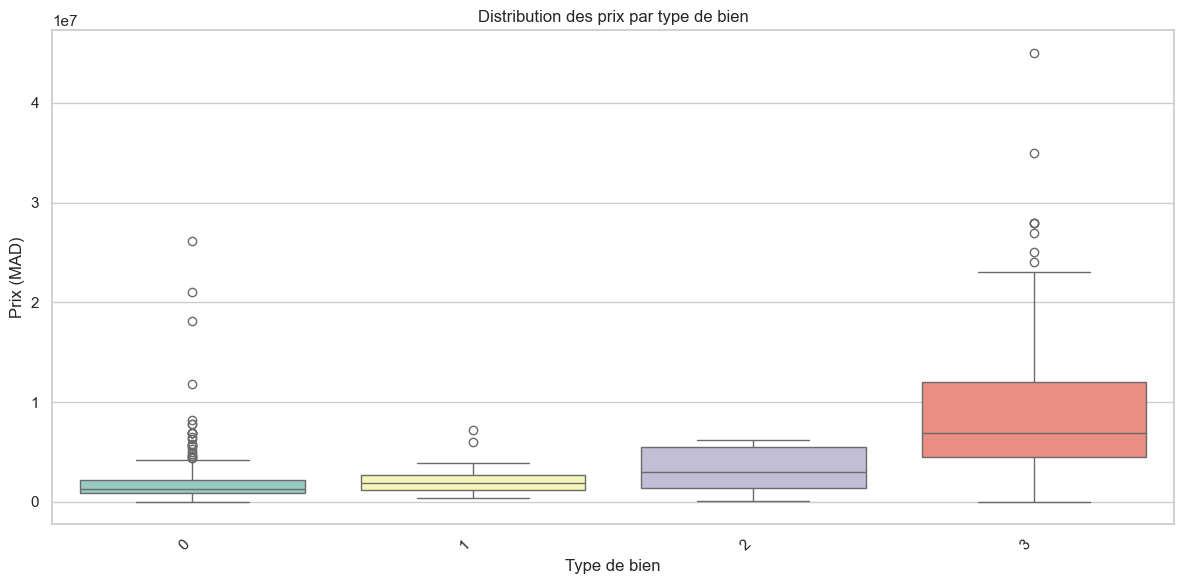

In [63]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='TypeBien', y='Prix', data=df, palette='Set3')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution des prix par type de bien')
plt.ylabel('Prix (MAD)')
plt.xlabel('Type de bien')
plt.tight_layout()
plt.show()


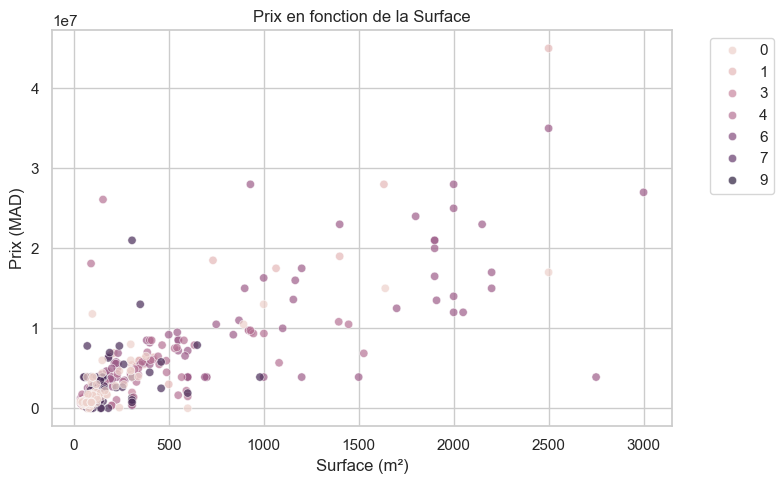

In [64]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Surface', y='Prix', hue='Ville', alpha=0.7)
plt.title('Prix en fonction de la Surface')
plt.xlabel('Surface (m²)')
plt.ylabel('Prix (MAD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\2737572590.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Chambres', y='Prix', palette='coolwarm')


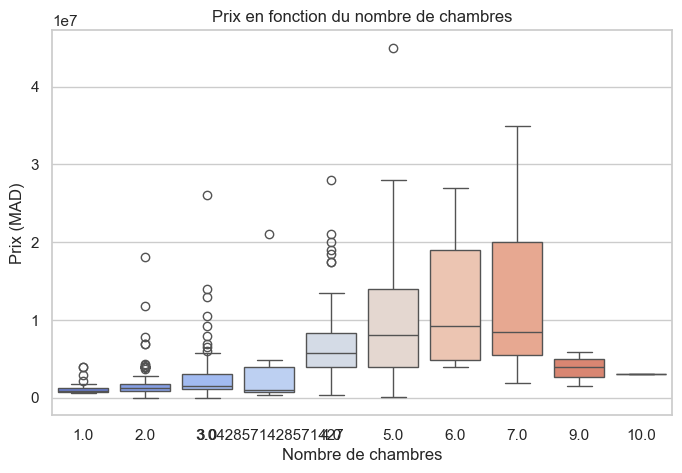

In [65]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Chambres', y='Prix', palette='coolwarm')
plt.title('Prix en fonction du nombre de chambres')
plt.xlabel('Nombre de chambres')
plt.ylabel('Prix (MAD)')
plt.show()


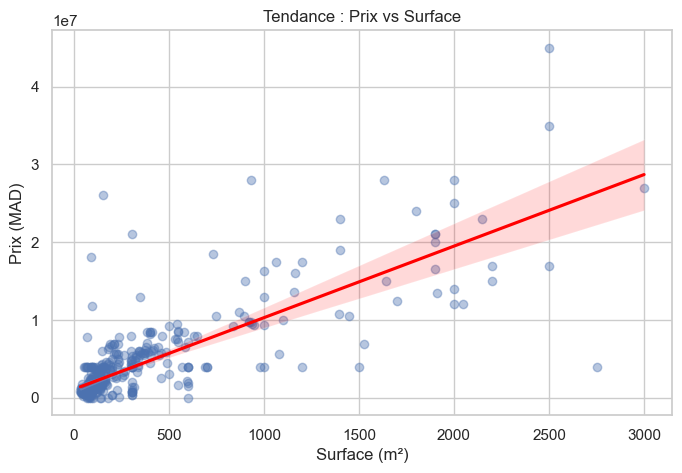

In [66]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x='Surface', y='Prix', scatter_kws={'alpha':0.4}, line_kws={"color":"red"})
plt.title('Tendance : Prix vs Surface')
plt.xlabel('Surface (m²)')
plt.ylabel('Prix (MAD)')
plt.show()


In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


In [68]:
# Supprimer les lignes avec valeurs manquantes
df_model = df[['Prix', 'Surface', 'Chambres', 'Pieces', 'SallesDeBain']].dropna()

X = df_model[['Surface', 'Chambres', 'Pieces', 'SallesDeBain']]
y = df_model['Prix']


In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [70]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),             # Normalisation des features
    ('regressor', LinearRegression())         # Modèle de régression
])


In [71]:
pipeline.fit(X_train, y_train)


,steps,"[('scaler', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [72]:
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🔎 Mean Squared Error (MSE) : {mse:.2f}")
print(f"✅ Coefficient de détermination R² : {r2:.2f}")


🔎 Mean Squared Error (MSE) : 9037611681527.08
✅ Coefficient de détermination R² : 0.73


In [73]:
# Récupérer les coefficients de la régression
coeffs = pipeline.named_steps['regressor'].coef_
features = X.columns

print("\n📊 Coefficients du modèle :")
for feat, coef in zip(features, coeffs):
    print(f"{feat} : {coef:.2f}")



📊 Coefficients du modèle :
Surface : 3817521.04
Chambres : -105160.43
Pieces : 246933.62
SallesDeBain : 329015.03


In [74]:
# Nettoyer les données (supprimer les lignes avec valeurs manquantes)
df_model = df[['Prix', 'Surface', 'Chambres', 'Pieces', 'SallesDeBain']].dropna()

# Variables explicatives (X) et cible (y)
X = df_model[['Surface', 'Chambres', 'Pieces', 'SallesDeBain']]
y = df_model['Prix']


In [75]:
# Nettoyer les données (supprimer les lignes avec valeurs manquantes)
df_model = df[['Prix', 'Surface', 'Chambres', 'Pieces', 'SallesDeBain']].dropna()

# Variables explicatives (X) et cible (y)
X = df_model[['Surface', 'Chambres', 'Pieces', 'SallesDeBain']]
y = df_model['Prix']


In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [77]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),         # Standardisation des variables
    ('regressor', LinearRegression())     # Régression multiple
])


In [78]:
pipeline.fit(X_train, y_train)


,steps,"[('scaler', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [79]:
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 MSE (Erreur quadratique moyenne) : {mse:.2f}")
print(f"✅ R² (Score de prédiction) : {r2:.2f}")


📉 MSE (Erreur quadratique moyenne) : 9037611681527.08
✅ R² (Score de prédiction) : 0.73


In [82]:
coeffs = pipeline.named_steps['regressor'].coef_
features = X.columns

print("\n Coefficients de la régression :")
for feature, coef in zip(features, coeffs):
    print(f"{feature} : {coef:.2f}")



 Coefficients de la régression :
Surface : 3817521.04
Chambres : -105160.43
Pieces : 246933.62
SallesDeBain : 329015.03


In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prédictions sur les données de test
y_pred = pipeline.predict(X_test)

# Métriques
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Affichage
print(f"✅ R² (coefficient de détermination) : {r2:.3f}")
print(f"📉 RMSE (Root Mean Squared Error)   : {rmse:.2f}")
print(f"📊 MAE (Mean Absolute Error)        : {mae:.2f}")



✅ R² (coefficient de détermination) : 0.729
📉 RMSE (Root Mean Squared Error)   : 3006262.08
📊 MAE (Mean Absolute Error)        : 1707664.82


In [87]:
# Récupérer les coefficients du modèle
coefficients = pipeline.named_steps['regressor'].coef_

# Récupérer les noms des variables (X doit être un DataFrame)
feature_names = X.columns

# Associer les coefficients aux variables
import pandas as pd
coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Afficher
print("📊 Importance des variables (coefficients):")
print(coef_df)


📊 Importance des variables (coefficients):
       Variable   Coefficient
0       Surface  3.817521e+06
3  SallesDeBain  3.290150e+05
2        Pieces  2.469336e+05
1      Chambres -1.051604e+05


C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\3972085100.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Variable', palette='viridis')
C:\Users\Dell\AppData\Local\Temp\ipykernel_18972\3972085100.py:9: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


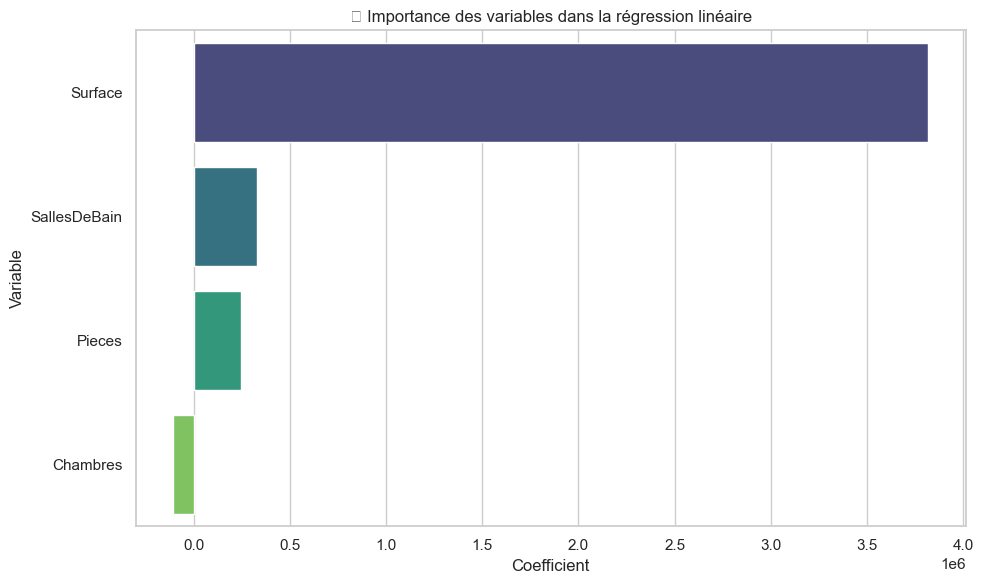

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Variable', palette='viridis')
plt.title("📌 Importance des variables dans la régression linéaire")
plt.xlabel("Coefficient")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [89]:
import numpy as np

# Appliquer log sur la variable cible (Prix)
y_log = np.log1p(y)  # log(1 + y), évite log(0)

# Re-diviser les données
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Réentraîner le pipeline avec y_log
pipeline.fit(X_train, y_train_log)

# Prédire et inverser la transformation pour les métriques
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)  # inverse de log1p
y_test = np.expm1(y_test_log)

# Réévaluer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ R² : {r2:.3f}")
print(f"📉 RMSE : {rmse:.2f}")
print(f"📊 MAE : {mae:.2f}")


✅ R² : 0.636
📉 RMSE : 3486546.97
📊 MAE : 1758537.28


In [94]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supposons que ton DataFrame est prêt et s'appelle df
# Séparation X / y
X = df.drop('Prix', axis=1)
y = df['Prix']

# Encodage / standardisation selon types de colonnes
numeric_features = ['Surface', 'Pieces', 'Chambres', 'SallesDeBain']
categorical_features = ['Ville', 'TypeBien']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Log transformation sur le prix
y_log = np.log1p(y)

# Split
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 1. Régression Linéaire
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_pipeline.fit(X_train, y_train_log)
y_pred_lr = np.expm1(lr_pipeline.predict(X_test))

# 2. Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train_log)
y_pred_rf = np.expm1(rf_pipeline.predict(X_test))

# 3. Gradient Boosting
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
])
gb_pipeline.fit(X_train, y_train_log)
y_pred_gb = np.expm1(gb_pipeline.predict(X_test))

# Évaluer les 3 modèles
models = {
    "Régression Linéaire": y_pred_lr,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb
}

print("📊 Comparaison des performances des modèles :\n")
for name, pred in models.items():
    print(f"🔎 {name}")
    print(f"  R²     : {r2_score(np.expm1(y_test_log), pred):.3f}")
    print(f"  RMSE   : {np.sqrt(mean_squared_error(np.expm1(y_test_log), pred)):.2f}")
    print(f"  MAE    : {mean_absolute_error(np.expm1(y_test_log), pred):.2f}\n")


📊 Comparaison des performances des modèles :

🔎 Régression Linéaire
  R²     : 0.608
  RMSE   : 3618147.98
  MAE    : 1695585.59

🔎 Random Forest
  R²     : 0.708
  RMSE   : 3123024.52
  MAE    : 1443347.27

🔎 Gradient Boosting
  R²     : 0.696
  RMSE   : 3189154.70
  MAE    : 1450429.08



In [100]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time

def extract_price(text):
    try:
        price = re.sub(r'[^\d]', '', text)
        return int(price)
    except:
        return None

def extract_surface(text):
    try:
        surface = re.search(r'(\d+)\s*m²', text)
        return int(surface.group(1)) if surface else None
    except:
        return None

def scrape_mubawab(max_pages=3):
    base_url = "https://www.mubawab.ma/fr/sc/immobilier-a-vendre:p:{}"
    all_annonces = []

    for page in range(1, max_pages + 1):
        print(f"Scraping page {page}...")
        url = base_url.format(page)
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Erreur page {page}")
            continue
        
        soup = BeautifulSoup(response.text, 'html.parser')
        annonces = soup.find_all("li", class_="listingBox")

        if not annonces:
            print(f"Aucune annonce trouvée page {page}")
            continue

        for ann in annonces:
            try:
                title = ann.find_all("h2", class_="listingTit").get_text(strip=True)
                location = ann.find_all("span", class_="listingH3").get_text(strip=True)
                price = ann.find_all("span", class_="priceTag").get_text(strip=True)
                price = extract_price(price)
                features_text = ann.find_all("div", class_="featuresBox").get_text(" ", strip=True)
                surface = extract_surface(features_text)

                all_annonces.append({
                    "Titre": title,
                    "Ville": location,
                    "Prix": price,
                    "Surface": surface
                })
            except Exception as e:
                continue

        time.sleep(1)

    return pd.DataFrame(all_annonces)


In [101]:
if __name__ == "__main__":
    df = scrape_mubawab(max_pages=3)
    df.to_csv("data/mubawab_scraped.csv", index=False)
    print(f"\n✅ {len(df)} annonces extraites")

    if df.empty:
        print("❌ Le DataFrame est vide. Vérifiez le scraping.")
    else:
        print("✅ Exemple de données :")
        print(df.head())


Scraping page 1...
Erreur page 1
Scraping page 2...
Erreur page 2
Scraping page 3...
Erreur page 3

✅ 0 annonces extraites
❌ Le DataFrame est vide. Vérifiez le scraping.


In [104]:
import joblib
joblib.dump(rf_pipeline, "random_forest_prix_immo.pkl")

['random_forest_prix_immo.pkl']